### PID control of `Snapbot`

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from pip import PID_ControllerClass
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.2]


### Initialize

In [2]:
xml_path = '../model/snapbot/robot_4_1245.xml'
env = MuJoCoParserClass(name='Snapbot',rel_xml_path=xml_path,VERBOSE=True)
PID = PID_ControllerClass(
    name = 'PID',dim = env.n_ctrl,
    k_p = 20.0, k_i = 0.1, k_d = 1.0,
    out_min = env.ctrl_ranges[:,0],
    out_max = env.ctrl_ranges[:,1],
    ANTIWU  = True)
print ("[%s] parsed."%(env.name))

n_body:[24]
geom_names:['floor', 'body', 'camera_module_1', 'camera_module_2', 'leg_module_1_1', 'leg_module_1_2', 'leg_module_1_3', 'leg_module_1_4', 'leg_module_1_4bar', 'leg_module_2_1', 'leg_module_2_2', 'leg_module_2_3', 'leg_module_2_4', 'leg_module_2_4bar', 'leg_module_4_1', 'leg_module_4_2', 'leg_module_4_3', 'leg_module_4_4', 'leg_module_4_4bar', 'leg_module_5_1', 'leg_module_5_2', 'leg_module_5_3', 'leg_module_5_4', 'leg_module_5_4bar']
n_body:[24]
body_names:['world', 'torso', 'Camera_module_1', 'Camera_module_2', 'Leg_module_1_1', 'Leg_module_1_2', 'Leg_module_1_3', 'Leg_module_1_4', 'Leg_module_1_4bar', 'Leg_module_2_1', 'Leg_module_2_2', 'Leg_module_2_3', 'Leg_module_2_4', 'Leg_module_2_4bar', 'Leg_module_4_1', 'Leg_module_4_2', 'Leg_module_4_3', 'Leg_module_4_4', 'Leg_module_4_4bar', 'Leg_module_5_1', 'Leg_module_5_2', 'Leg_module_5_3', 'Leg_module_5_4', 'Leg_module_5_4bar']
n_joint:[19]
joint_names:['free', 'camera_1', 'camera_2', 'leg_1_2', 'leg_1_3', 'leg_1_4', 'leg_1

### PID Control

In [3]:
env.init_viewer(viewer_title='Snapbot',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=78,distance=2.0,elevation=-36,lookat=[0.02,  0.16, -0.37],
                  VIS_TRANSPARENT=True,VIS_CONTACTPOINT=True,
                  contactwidth=0.15,contactheight=0.15,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
max_tick = 1000
t_list      = np.zeros(shape=(max_tick))
x_trgt_list = np.zeros(shape=(max_tick,env.n_ctrl))
q_list      = np.zeros(shape=(max_tick,env.n_ctrl))
torque_list = np.zeros(shape=(max_tick,env.n_ctrl))
PID.reset()
env.reset()
imgs,img_ticks = [],[]
while (env.tick<max_tick) and env.is_viewer_alive():
    # Change 'x_trgt' every 100 ticks
    if (env.tick)%(100) == 0:
        x_trgt = 45*np.pi/180.0*(-1.0+2.0*np.random.rand(env.n_ctrl))
    # PD controller
    q = env.data.qpos[env.ctrl_joint_idxs] # snapbot joint position
    PID.update(x_trgt=x_trgt,t_curr=env.get_sim_time(),x_curr=q,VERBOSE=False)
    # Step
    torque = PID.out()
    env.step(ctrl=torque)
    env.render()
    # Append
    t_list[env.tick-1]        = env.get_sim_time()
    x_trgt_list[env.tick-1,:] = PID.x_trgt
    q_list[env.tick-1,:]      = q
    torque_list[env.tick-1,:] = torque
    # Print and save image 
    if (env.tick)%(max_tick//10)==0 or (env.tick==1):
        img = env.grab_image()
        imgs.append(img)
        img_ticks.append(env.tick)
env.close_viewer()    
print ("Done.")

Done.


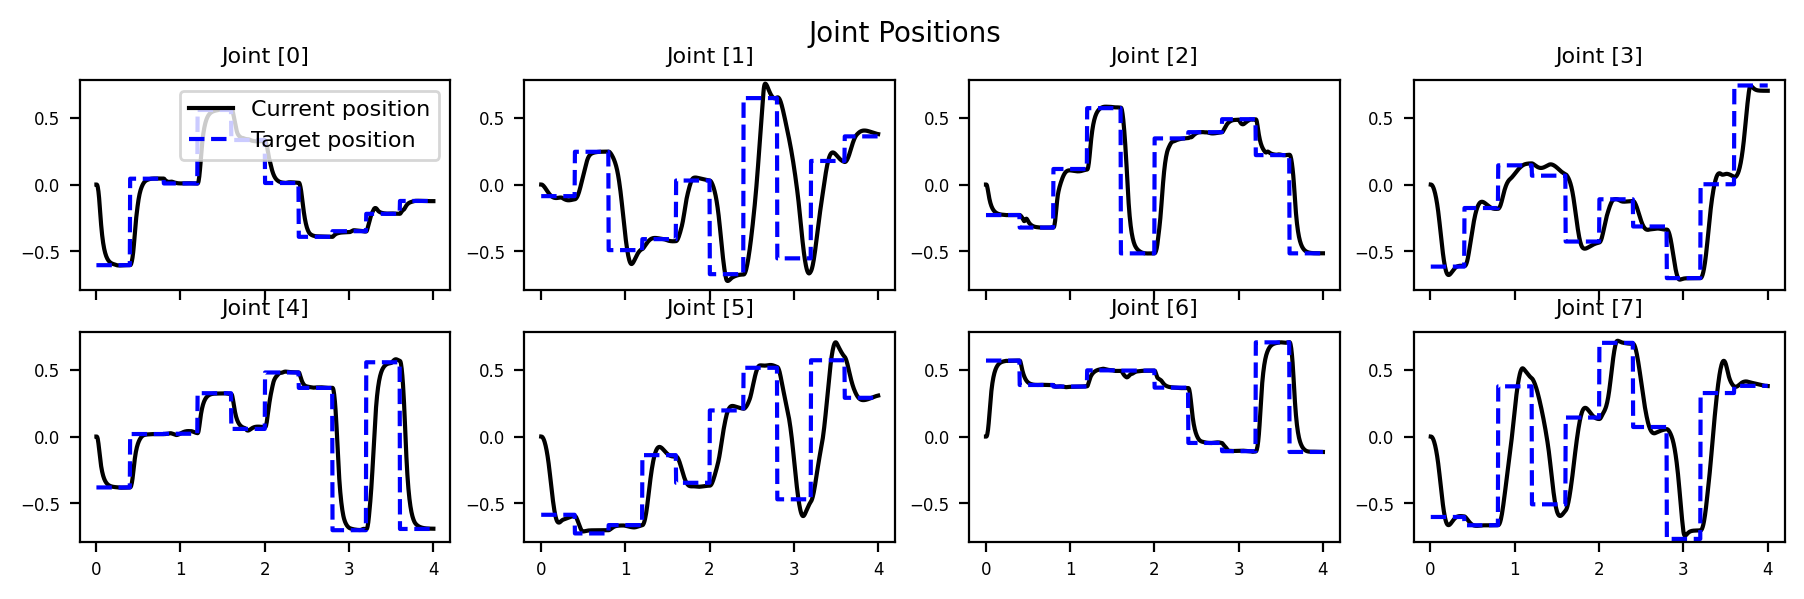

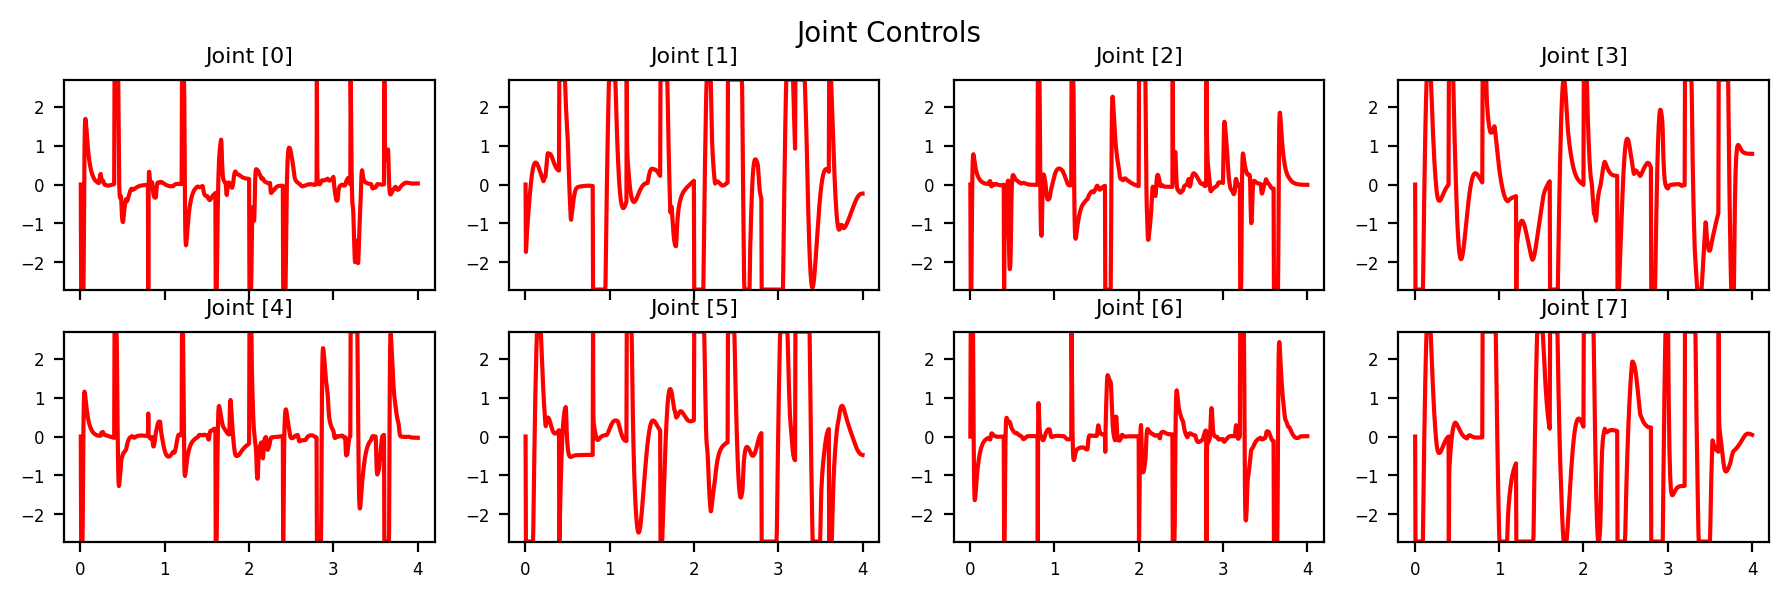

In [4]:
# Plot target and current joint position
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(11,3))
fig.suptitle("Joint Positions", fontsize=10)
for a_idx,ax in enumerate(axs.ravel()):
    ax.plot(t_list,q_list[:,a_idx],color='k',label='Current position')
    ax.plot(t_list,x_trgt_list[:,a_idx],'--',color='b',label='Target position')
    ax.set_ylim(bottom=-45*np.pi/180.0,top=45*np.pi/180.0)
    ax.set_title('Joint [%d]'%(a_idx),fontsize=8)
    if a_idx == 0: ax.legend(fontsize=8)
plt.show()
# Plot control output
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(11,3))
fig.suptitle("Joint Controls", fontsize=10)
for a_idx,ax in enumerate(axs.ravel()):
    ax.plot(t_list,torque_list[:,a_idx],color='r')
    ax.set_ylim(bottom=env.ctrl_ranges[a_idx,0],top=env.ctrl_ranges[a_idx,1])
    ax.set_title('Joint [%d]'%(a_idx),fontsize=8)
plt.show()

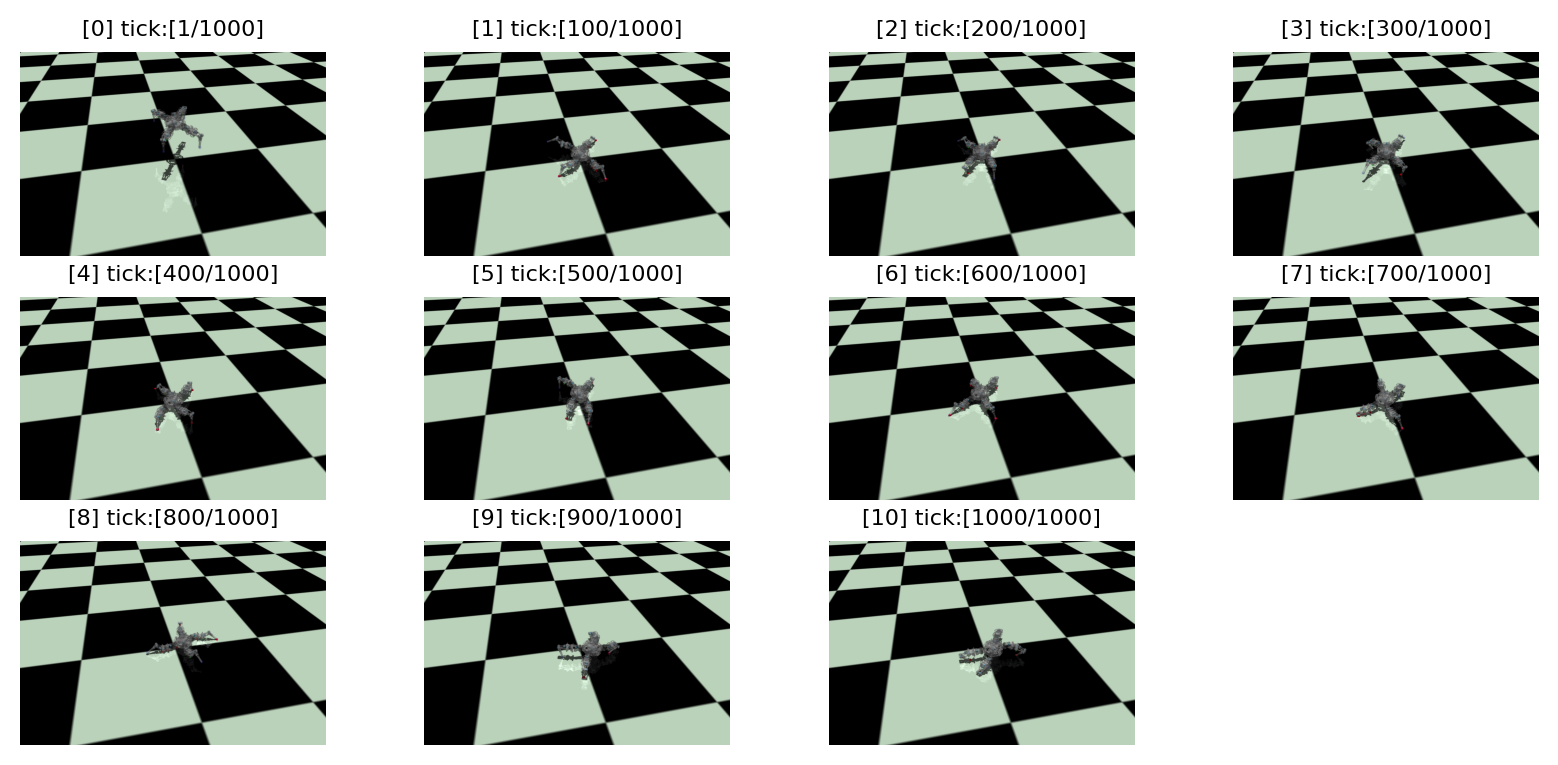

In [5]:
n_row = np.ceil(len(imgs)/4).astype(np.int32)
fig = plt.figure(figsize=(10,1.5*n_row))
for i_idx,img in enumerate(imgs):
    ax = fig.add_subplot(np.ceil(len(imgs)/4).astype(np.int32),4,i_idx+1)
    ax.imshow(img)
    ax.set_title('[%d] tick:[%d/%d]'%(i_idx,img_ticks[i_idx],max_tick),fontsize=8)
    ax.axis('off')